# Analisis

In [1]:
# Modulos
import numpy as np
import matplotlib.pyplot as plt
import sympy as spy
import control as ctl
from sympy.core.compatibility import iterable
from reliability.Other_functions import crosshairs as csr
%matplotlib qt

# Funciones auxiliares
def mem2mem(equation,opp):
    """mem2mem:
        Aplica una operacion sencilla en ambos miembros de una ecuacion.

    Args:
        equation: Ecuacion a operar.
        opp: Termino para operar en ambos miembros.

    Returns: 
        Ecuacion de resultado luego de operar.
    """
    sel=opp[0]
    expr=spy.sympify(opp[1::])
    
    if sel=="+":
        return spy.Eq(equation.lhs+expr,equation.rhs+expr)
    elif sel=="-":
        return spy.Eq(equation.lhs-expr,equation.rhs-expr)
    elif sel=="*":
        return spy.Eq(equation.lhs*expr,equation.rhs*expr)
    elif sel=="/":
        return spy.Eq(equation.lhs/expr,equation.rhs/expr)

def disp(ecuaciones,titulo=""):
    print(titulo + "\n")
    
    if type(ecuaciones)!=iterable:
        spy.pprint(ecuaciones)
    
    else:
        for ecc in ecuaciones:
            spy.pprint(ecc)

    print("\n" + "-"*80)

In [2]:
#ecuaciones
# V = Im*(rm+lm*s) + kv*Wm
# Tm = Wm*(Jm*s + bm) + T1
# T2 = W2*(J*s + b2)
V,Im,rm,lm,kv,Wm=spy.symbols("V,Im,rm,lm,kv,Wm")
Tm,Jm,s,bm,T1=spy.symbols("Tm,Jm,s,bm,T1")
T2,W2,J,b2=spy.symbols("T2,W2,J,b2")

eqq1=spy.Eq(V,Im*(rm+lm*s) + kv*Wm)
eqq2=spy.Eq(Tm,Wm*(Jm*s + bm) + T1)
eqq3=spy.Eq(T2,W2*(J*s + b2))

disp((eqq1,eqq2,eqq3),"Ecuaciones:")

#igualdades auxiliares
# Tm = km*Im
# n = N1/N2 = W2/W1 = T1/T2
km,Im,n=spy.symbols("km,Im,n")

#cancelar T1 y T1
aux0=spy.Eq(T1,spy.solve(eqq2,T1)[0])
aux1=mem2mem(eqq3,"*n").replace(T2*n,T1)

aux2=spy.Eq(aux0.lhs-aux1.lhs,aux0.rhs-aux1.rhs)

disp((eqq1,aux2),"Cancelar T1 y T2:")

#cancelar Tm e Im
aux3=spy.Eq(Tm,spy.solve(aux2,Tm)[0])
aux4=spy.Eq(Im,spy.solve(eqq1,Im)[0])
aux4=mem2mem(aux4,"*km").replace(Im*km,Tm)

aux5=spy.Eq(aux3.lhs-aux4.lhs,aux3.rhs-aux4.rhs)

disp(aux5,"Cancelar Im y Tm:")

#resolver para W2/V
aux6=spy.Eq(Wm,spy.solve(aux5,Wm)[0])
aux6=mem2mem(aux6,"*n").replace(Wm*n,W2)

aux7=spy.Eq(W2,spy.solve(aux6,W2)[0])
aux7=mem2mem(aux7,"/V")

aux7=spy.Eq(W2/V,aux7.rhs.collect(s))

disp(aux7,"Resolver para W2/V:")

#armar funcion de transferencia G = P2/V
aux8=mem2mem(aux7,"/s")

P2=spy.symbols("P2")
eqqG=spy.Eq(P2/V,aux8.rhs)

disp(eqqG,"Funcion de transferencia:")


Ecuaciones:

(V = Im⋅(lm⋅s + rm) + Wm⋅kv, Tm = T₁ + Wm⋅(Jm⋅s + bm), T₂ = W₂⋅(J⋅s + b₂))

--------------------------------------------------------------------------------
Cancelar T1 y T2:

(V = Im⋅(lm⋅s + rm) + Wm⋅kv, 0 = -Jm⋅Wm⋅s + Tm - W₂⋅n⋅(J⋅s + b₂) - Wm⋅bm)

--------------------------------------------------------------------------------
Cancelar Im y Tm:

                                           km⋅(V - Wm⋅kv)
0 = J⋅W₂⋅n⋅s + Jm⋅Wm⋅s + W₂⋅b₂⋅n + Wm⋅bm - ──────────────
                                             lm⋅s + rm   

--------------------------------------------------------------------------------
Resolver para W2/V:

W₂                                             km⋅n                           
── = ─────────────────────────────────────────────────────────────────────────
V        2                       2 ⎛      2        ⎞     ⎛   2                
     b₂⋅n ⋅rm + bm⋅rm + km⋅kv + s ⋅⎝J⋅lm⋅n  + Jm⋅lm⎠ + s⋅⎝J⋅n ⋅rm + Jm⋅rm + b₂

               
───────────────
     2    

# Funcion de transferencia a lazo abierto

In [3]:
#armar funcion de transferencia de lazo abierto
ssr,pwm,Av,FTLA=spy.symbols("ssr,pwm,Av,FTLA")

eqqFTLA=spy.Eq(FTLA,ssr*pwm*Av*eqqG.rhs)

disp(eqqFTLA,"Funcion de transferencia a lazo abierto:")

Funcion de transferencia a lazo abierto:

                                             Av⋅km⋅n⋅pwm⋅ssr                  
FTLA = ───────────────────────────────────────────────────────────────────────
         ⎛    2                       2 ⎛      2        ⎞     ⎛   2           
       s⋅⎝b₂⋅n ⋅rm + bm⋅rm + km⋅kv + s ⋅⎝J⋅lm⋅n  + Jm⋅lm⎠ + s⋅⎝J⋅n ⋅rm + Jm⋅rm

                     
─────────────────────
          2        ⎞⎞
 + b₂⋅lm⋅n  + bm⋅lm⎠⎠

--------------------------------------------------------------------------------


# Planta final

In [4]:
#parametros de la planta
#sensor(V/°): +/-5V a +/- 20°
ppssr=5/20
#pwm(%D/V): +/-5V es +/-100D%
pppwm=1/5 
#ganancia(V/%D): +/-100D% son +/-12V
ppAv=12/100

eqqFTLA=eqqFTLA.subs({ssr:ppssr, 
                      pwm:pppwm,
                      Av:ppAv})

#motor
pprm = 26.9 
pplm = 600E-6
ppJm = 1.5E-7
ppkm = 30.82E-3
ppkv = 30.82E-3
ppbm = 3.7628E-5

eqqFTLA=eqqFTLA.subs({rm:pprm, 
                      lm:pplm,
                      Jm:ppJm,
                      km:ppkm,
                      kv:ppkv,
                      bm:ppbm})

#caja reductora
ppn=1/4

#seguidor
#disco dentado de pla: h=1cm, r=5cm, densidad=1.32gr/cm3, J=1/2*densidad*vol*r**2
densidad=1.32/1000
radio=5
vol=(np.pi*radio**2)*1

#inercia (gr*cm2)
ppJ=1/2*densidad*vol*radio**2
#pasar a Kg*m2
ppJ=ppJ*1E-7
#friccion 
ppb2=2*ppbm

eqqFTLA=eqqFTLA.subs({n:ppn, 
                      J:ppJ,
                      b2:ppb2}).expand()

disp(eqqFTLA,"Planta:")

num=[spy.numer(eqqFTLA.rhs)]
den=[spy.denom(eqqFTLA.rhs).coeff(s,pot) for pot in reversed(range(4))]

print("Coeficientes:")
print((num,den))


Planta:

                                    4.623e-5                             
FTLA = ──────────────────────────────────────────────────────────────────
                             3                        2                  
       9.48596511360217e-11⋅s  + 4.27827325926497e-6⋅s  + 0.00208858975⋅s

--------------------------------------------------------------------------------
Coeficientes:
([4.62300000000000e-5], [9.48596511360217e-11, 4.27827325926497e-6, 0.00208858975000000, 0])


# Funcion de transferencia a lazo abierto

In [7]:
FTLA=ctl.tf([4.62300000000000e-5], [9.48596511360217e-11, 4.27827325926497e-6, 0.00208858975000000, 0])

print(FTLA)


                4.623e-05
------------------------------------------
9.486e-11 s^3 + 4.278e-06 s^2 + 0.002089 s



# Funcion de transferencia a lazo cerrado

In [8]:
#realimentacion unitaria
H=1
FTLC=ctl.feedback(FTLA,1)

print("Funcion de transferencia a lazo cerrado:")
print(FTLC)

Funcion de transferencia a lazo cerrado:

                      4.623e-05
------------------------------------------------------
9.486e-11 s^3 + 4.278e-06 s^2 + 0.002089 s + 4.623e-05



# Respuesta al escalon original

KeyboardInterrupt: 

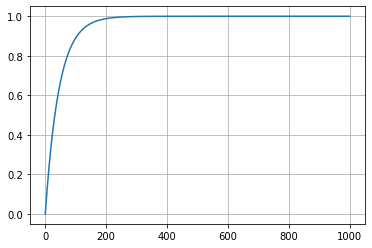

In [9]:
#respuesta al escalon
t,y=ctl.step_response(ctl.feedback(FTLA,1),1000)

fig=plt.figure()
plt.plot(t,y)
plt.grid()
csr()
plt.draw()

while plt.waitforbuttonpress()!=True:
    pass
plt.close(fig)